In [1]:
import sqlalchemy
from sqlalchemy import create_engine,Column,Integer,String,ForeignKey,Table,Text,inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker,relationship

import os
import numpy as np
import pandas as pd
import glob
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from config import *
from db_config import *

In [2]:
data = []
mis = []
counter = 1
no_order = []
for part in session.query(Part).order_by(Part.part_id):
    counter += 1
    if counter == 750:
        break
    print(part.part_id)        
    try:
        order_num = int(part.fragments[0].twist_orders[0].sub_name[-3:])
    except:
        order_num = 12
        no_order.append(part.part_id)
        
    frags = len([frag for frag in part.fragments])
    attempts = [well for well in part.wells if well.plates.plate_type == 'seq_plate' and well.misplaced != 'True']
    tups = []
    for well in attempts:
        build = int(well.plates.builds.build_name[-3:])
        tups.append([well.seq_outcome,build])
    tups = sorted(tups, key=lambda tup: tup[1])
    attempts = [out for out,num in tups]
    misplaced = [well.seq_outcome for well in part.wells if well.plates.plate_type == 'seq_plate' and well.misplaced == 'True']
    if len(misplaced) == 0:
        misplaced = ['N/A']
    mis.append(misplaced)
    if len(attempts) == 0:
        attempts += ['N/A','N/A']
    elif len(attempts) == 1:
        attempts += ['N/A']
    elif len(attempts) == 2:
        print('two attemps')
    else:
        print(len(attempts))
        input('More than two attempts')
    row = [part.part_id,part.status,len(part.seq),frags,attempts[0],attempts[1],part.cloning_enzyme,order_num]
    data.append(row)

BBF10K_000001
BBF10K_000002
BBF10K_000003
BBF10K_000004
two attemps
BBF10K_000005
BBF10K_000006
BBF10K_000007
BBF10K_000008
two attemps
BBF10K_000009
BBF10K_000010
BBF10K_000011
BBF10K_000012
BBF10K_000013
two attemps
BBF10K_000014
two attemps
BBF10K_000015
BBF10K_000016
two attemps
BBF10K_000017
BBF10K_000018
BBF10K_000019
BBF10K_000020
BBF10K_000021
BBF10K_000022
BBF10K_000023
BBF10K_000024
BBF10K_000025
BBF10K_000026
two attemps
BBF10K_000027
BBF10K_000028
BBF10K_000029
BBF10K_000030
two attemps
BBF10K_000031
BBF10K_000032
two attemps
BBF10K_000033
two attemps
BBF10K_000034
BBF10K_000035
BBF10K_000036
two attemps
BBF10K_000037
BBF10K_000038
BBF10K_000039
BBF10K_000040
BBF10K_000041
BBF10K_000042
two attemps
BBF10K_000043
BBF10K_000044
BBF10K_000045
two attemps
BBF10K_000046
BBF10K_000047
two attemps
BBF10K_000048
BBF10K_000049
BBF10K_000050
BBF10K_000051
BBF10K_000052
BBF10K_000053
BBF10K_000054
two attemps
BBF10K_000055
BBF10K_000056
two attemps
BBF10K_000057
BBF10K_000058
BBF10K_0

two attemps
BBF10K_000498
BBF10K_000499
two attemps
BBF10K_000500
BBF10K_000501
BBF10K_000502
BBF10K_000503
two attemps
BBF10K_000504
two attemps
BBF10K_000505
BBF10K_000506
BBF10K_000507
BBF10K_000508
BBF10K_000509
two attemps
BBF10K_000510
BBF10K_000511
BBF10K_000512
BBF10K_000513
BBF10K_000514
BBF10K_000515
BBF10K_000516
BBF10K_000517
BBF10K_000518
BBF10K_000519
BBF10K_000520
BBF10K_000521
BBF10K_000522
BBF10K_000523
BBF10K_000524
BBF10K_000525
BBF10K_000526
BBF10K_000527
BBF10K_000528
BBF10K_000529
BBF10K_000530
BBF10K_000531
BBF10K_000532
BBF10K_000533
BBF10K_000534
BBF10K_000535
BBF10K_000536
BBF10K_000537
BBF10K_000538
BBF10K_000539
BBF10K_000540
BBF10K_000541
BBF10K_000542
two attemps
BBF10K_000543
BBF10K_000544
BBF10K_000545
BBF10K_000546
BBF10K_000547
BBF10K_000548
BBF10K_000549
BBF10K_000550
BBF10K_000551
BBF10K_000552
BBF10K_000553
BBF10K_000554
BBF10K_000555
BBF10K_000556
two attemps
BBF10K_000557
BBF10K_000558
BBF10K_000559
BBF10K_000560
BBF10K_000561
BBF10K_000562
BBF10K

In [3]:
import json
print(no_order)
missing = []
for part in no_order:
    for file in glob.glob('../data/{}/{}.json'.format(part,part)):
        print(file)
        with open(file,"r") as json_file:
            j_data = json.load(json_file)
        missing.append([part,j_data['info']['documentation']['gene_name'],j_data['info']['order_number']])
print(missing)

missing = np.array(missing)

missing_df = pd.DataFrame({
    'Gene ID':missing[:,0],
    'Gene Name':missing[:,1],
    'Order Listed':missing[:,2]
})

missing_df.to_csv('./missing_fragments.csv')

['BBF10K_000745']
../data/BBF10K_000745/BBF10K_000745.json
[['BBF10K_000745', 'NC_012416.1:383374-385488', '']]


In [4]:
miss = pd.read_csv('./missing_fragments.csv')
sub = pd.read_csv('../submissions/submission005.csv')
seqs = sub['FASTA_seq'].tolist()
no_order = miss['Gene ID']

sub5 = session.query(Twist_order).filter(Twist_order.sub_name == 'submission005').one()

for part in no_order:
    p = session.query(Part).filter(Part.part_id == part).first()
    print(p.part_id)
    for fragment in p.fragments:
#         print(fragment.fragment_name,fragment.seq,fragment.twist_orders)
        if fragment.seq in seqs:
            print('found')
#             sub5.fragments.append(fragment)
for frag in sub5.fragments:
    print(frag.fragment_name,frag.id)

# session.commit()

BBF10K_000745
BBF10K_000455_1 1246
BBF10K_000455_2 1247
BBF10K_000456_1 1248
BBF10K_000457_1 1249
BBF10K_000458_1 1250
BBF10K_000459_1 1251
BBF10K_000459_2 1252
pIP501_1 1554
pIP501_2 1555
pIP501_3 1556
pIP501_4 1557
pIP501_5 1558
pIP501_6 1559
pIP501_7 1560
pIP501_8 1561
pIP501_9 1562
Collagenase_1 1547
Collagenase_2 1548
Neutral Protease_1 1549
Cre Recombinase_1 1550
Flp recombinase_1 1551
A0A085WQF1.1_1 1552
A0A085WQF1.1_2 1553


In [5]:
data = np.array(data)
data_df = pd.DataFrame({
    'Part':data[:,0],
    "Status":data[:,1],
    'Length':data[:,2],
    'Frags':data[:,3],
    'Enzyme':data[:,6],
    'Order':data[:,7],
    'Attempt_1':data[:,4],
    'Attempt_2':data[:,5],
    'Misplaced':mis
})
simple_status = []
for attempts in zip(data_df['Attempt_1'].tolist(),data_df['Attempt_2'].tolist()):
    row = []
    for att in attempts:
        if "mutation" in att:
            row.append('cloning_mutation')
        elif "bad" in att:
            row.append('sequence_failure')
        elif att == 'cloning_error':
            row.append('cloning_failure')
        else:
            row.append(att)
    simple_status.append(row)
simple_status = np.array(simple_status)
data_df['Attempt_1_G'] = simple_status[:,0]
data_df['Attempt_2_G'] = simple_status[:,1]

data_df = data_df[['Part','Status','Length','Frags','Enzyme','Order','Attempt_1_G','Attempt_2_G','Attempt_1','Attempt_2','Misplaced']]
data_df['Length'] = pd.to_numeric(data_df['Length'])
data_df['Frags'] = pd.to_numeric(data_df['Frags'])

data_df.sort_values(by=['Length'])



,Part,Status,Length,Frags,Enzyme,Order,Attempt_1_G,Attempt_2_G,Attempt_1,Attempt_2,Misplaced
401,BBF10K_000402,cloning_mutation,114,1,BbsI,1,sequence_failure,N/A,bad_reverse,N/A,[cloning_mutation]
403,BBF10K_000404,sequence_confirmed,135,1,BbsI,1,sequence_confirmed,N/A,sequence_confirmed,N/A,[sequence_confirmed]
405,BBF10K_000406,sequence_confirmed,141,1,BbsI,1,sequence_confirmed,N/A,sequence_confirmed,N/A,[sequence_confirmed]
407,BBF10K_000408,sequence_confirmed,153,1,BbsI,1,sequence_confirmed,N/A,sequence_confirmed,N/A,[sequence_confirmed]
409,BBF10K_000410,sequence_confirmed,165,1,BbsI,1,sequence_failure,sequence_confirmed,bad_reverse,sequence_confirmed,[sequence_confirmed]
411,BBF10K_000412,sequence_confirmed,180,1,BbsI,1,sequence_confirmed,N/A,sequence_confirmed,N/A,"[sequence_confirmed, sequence_confirmed]"
413,BBF10K_000414,cloning_mutation,183,1,BbsI,1,sequence_failure,cloning_mutation,bad_reverse,mutation_7.0-2.0,[N/A]
415,BBF10K_000416,sequence_confirmed,186,1,BbsI,1,sequence_confirmed,N/A,sequence_confirmed,N/A,"[sequence_confirmed, sequence_confirmed]"
417,BBF10K_000418,sequence_confirmed,192,1,BbsI,1,sequence_confirmed,N/A,sequence_confirmed,N/A,"[sequence_confirmed, sequence_confirmed]"
419,BBF10K_000420,sequence_confirmed,198,1,BbsI,1,sequence_confirmed,N/A,sequence_confirmed,N/A,"[sequence_confirmed, sequence_confirmed]"


In [ ]:
check = ['BBF10K_000678','BBF10K_000720','BBF10K_000723']

check_df = data_df[data_df['Part'] == check[2]]
check_df

In [ ]:
print('First Attempt:\n',data_df['Attempt_1_G'].value_counts())
print('\nSecond Attempt:\n',data_df['Attempt_2_G'].value_counts())

In [ ]:
btgzi = data_df[data_df['Enzyme'] == 'BtgZI']

In [ ]:
data_df.groupby(data_df.Status).Length.plot.hist(legend=True)
data_df.groupby(data_df.Status).describe()
data_df.boxplot(by='Status', column='Length', figsize=(12,12))

Empty DataFrame
Columns: [Part, Status, Length, Frags, Enzyme, Order, Attempt_1_G, Attempt_2_G, Attempt_1, Attempt_2, Misplaced]
Index: []


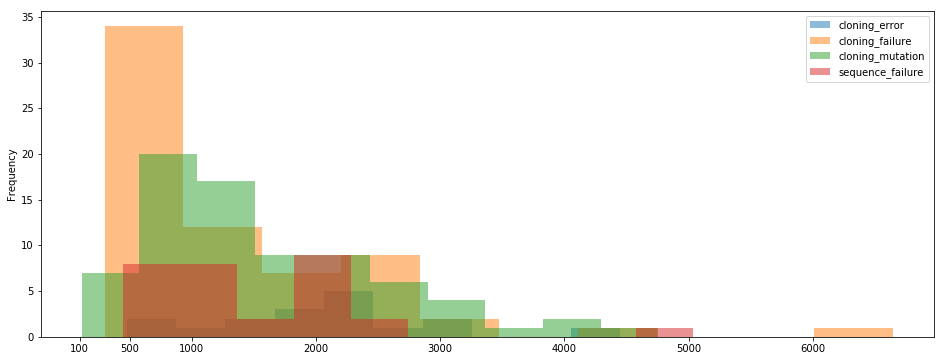

In [7]:
data_b = data_df[data_df['Enzyme'] == 'BbsI']
data_b = data_b.drop([743])

sections = [0,300,600,900,1200,1500,1800,2100,20000]
pairs = [[i,j] for i,j in zip(sections,sections[1:])]

length_dfs = []
for bot,top in pairs:
    temp_df = data_b[data_b['Length'] > bot]
    temp_df = temp_df[temp_df['Length'] <= top]
    length_dfs.append(temp_df)

# for i,df in enumerate(length_dfs):
#     print(sections[i],sections[i+1])
#     print(df['Status'].value_counts())

data_fail = data_b[data_b.Status != 'sequence_confirmed']
data_fail = data_fail[data_fail.Status != 'ordered']

# data_b = data_df[data_df.Status != 'received']


fig, ax = plt.subplots()

# ax.set_xscale('log')
ax.set_xticks([100,500,1000,2000,3000,4000,5000,6000])

data_b.groupby(data_fail.Status).Length.plot.hist(ax=ax,alpha=0.5,legend=True,figsize=(16,6),bins=10)

data_b.groupby(data_fail.Status).describe()
# data_b.boxplot(by='Status', column='Length', figsize=(12,12))

In [ ]:
## SYNTHESIS FAILURES PLOTTED AGAINST SEQUENCE LENGTH

data_order = data_b[data_b.Status == 'ordered']
fig, ax = plt.subplots()

ax.set_xticks([1000,2000,3000,4000,5000])

data_order.groupby(data_order.Status).Length.plot.hist(ax=ax,alpha=0.5,legend=True,figsize=(16,6),bins=10)

# data_order.groupby(data_order.Status).describe()
# data_order.Length.describe()

plt.xlabel('Seqence Length (bp)')
plt.ylabel('Counts')
plt.title('Synthesis Abandonment Versus Sequence Length')
plt.show()
data_order.Length.describe()

In [ ]:
## BBREAKDOWN OF OUTCOMES BY NUMBER OF FRAGMENTS

failures = (data_fail.groupby('Frags')['Status'].value_counts() / data_b.groupby('Frags')['Status'].agg(len))
failures.name = 'Percent'
norm_frag = pd.DataFrame(failures).reset_index()
norm_frag.Percent = norm_frag.Percent * 100

dims = (16, 6)

fig1, ax = plt.subplots(figsize=dims)
g = sns.barplot(ax=ax,data=norm_frag, x='Frags', y='Percent', hue='Status',palette="Spectral")
g.set_yscale('log')
plt.title("Normalized Stat Percentage vs. Number of Fragments")
plt.show()

total_raw = (data_b.groupby('Frags')['Status'].value_counts())
total_raw.name = 'Count'
total_raw = pd.DataFrame(total_raw).reset_index()

# flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# sns.set_palette(flatui)

fig2, ax = plt.subplots(figsize=dims)
t = sns.barplot(ax=ax,data=total_raw, x='Frags', y='Count', hue='Status',palette='Spectral')
t.set_yscale('log')
plt.title("Raw Status Count vs. Number of Fragments")
plt.show()

In [ ]:
## SECOND ATTEMPT BREAKDOWN

# Elimination of irrelevant information for the plots
data_att = data_b[data_b.Status != 'ordered']
data_att = data_att[data_att.Status != 'received']
data_att = data_att[data_att.Attempt_1_G != 'sequence_confirmed']
data_att = data_att.drop([560])
data_attempt = data_att[data_att.Attempt_2_G != 'N/A']

# Normalizing the data by dividing the counts of each 2nd outcome by the total counts of each group of 1st outcomes
attempts_norm = (data_attempt.groupby('Attempt_1_G')['Attempt_2_G'].value_counts() / data_attempt.groupby('Attempt_1_G')['Attempt_2_G'].agg(len))
attempts_norm.name = 'Percent'
attempts_norm = pd.DataFrame(attempts_norm).reset_index()
attempts_norm.Percent = attempts_norm.Percent * 100

# Plot normalized data
dims = (16, 6)
fig1, ax = plt.subplots(figsize=dims)
p = sns.barplot(data=attempts_norm, x='Attempt_1_G', y='Percent', hue='Attempt_2_G',palette="Spectral").set_title("Normalized 2nd Attempt Outcomes")
plt.xlabel("1st Attempt Outcome")
plt.show()

# Caluclate the raw counts
attempts_raw = (data_attempt.groupby('Attempt_1_G')['Attempt_2_G'].value_counts())
attempts_raw.name = 'Count'
attempts_raw = pd.DataFrame(attempts_raw).reset_index()

# Plot the raw counts
fig2, ax = plt.subplots(figsize=dims)
g = sns.barplot(data=attempts_raw, x='Attempt_1_G', y='Count', hue='Attempt_2_G',palette="Spectral").set_title("2nd Attempt Outcomes")
plt.xlabel("1st Attempt Outcome")
plt.show()
attempts_norm.describe()

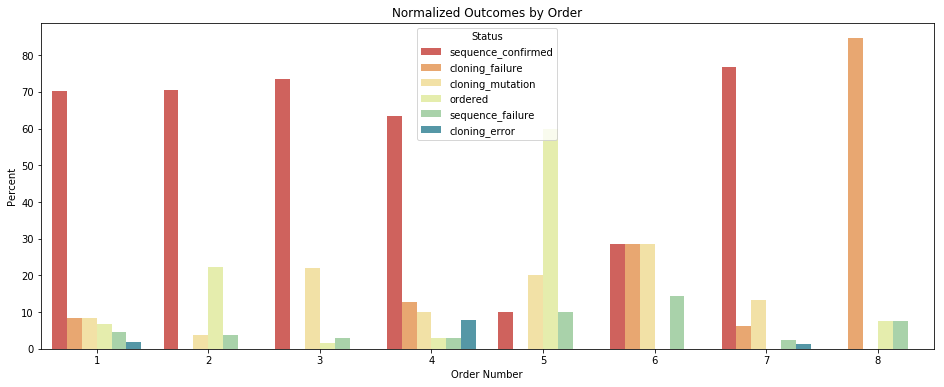

/Users/conarymeyer/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


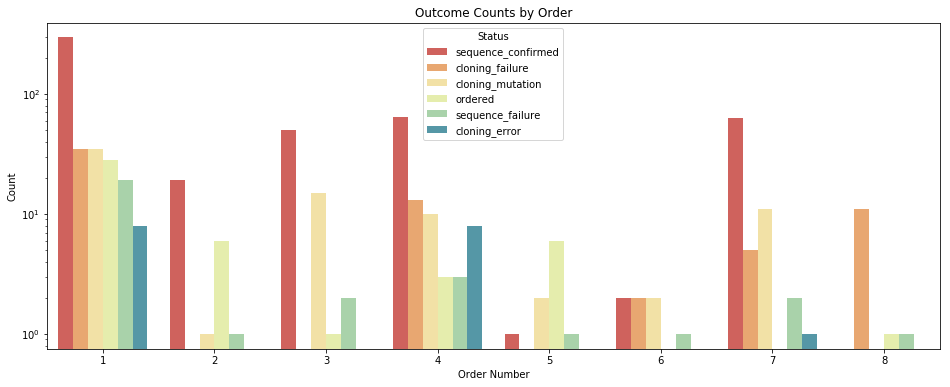

,Percent
count,36.000000
mean,22.222222
std,25.833598
min,1.219512
25%,4.318783
50%,9.950495
75%,28.571429
max,84.615385


In [12]:
## BREAKING DOWN CLONING OUTCOMES BY ORDER NUMBER

# Normalizing the data by dividing the counts of each 2nd outcome by the total counts of each group of 1st outcomes
order_norm = (data_b.groupby('Order')['Status'].value_counts() / data_b.groupby('Order')['Status'].agg(len))
order_norm.name = 'Percent'
order_norm = pd.DataFrame(order_norm).reset_index()
order_norm.Percent = order_norm.Percent * 100

# Plot normalized data
dims = (16, 6)
fig1, ax = plt.subplots(figsize=dims)
p = sns.barplot(data=order_norm, x='Order', y='Percent', hue='Status',palette="Spectral").set_title("Normalized Outcomes by Order")
plt.xlabel("Order Number")
plt.show()

# Caluclate the raw counts
order_raw = (data_b.groupby('Order')['Status'].value_counts())
order_raw.name = 'Count'
order_raw = pd.DataFrame(order_raw).reset_index()

# Plot the raw counts
fig2, ax = plt.subplots(figsize=dims)
g = sns.barplot(data=order_raw, x='Order', y='Count', hue='Status',palette="Spectral")

g.set_yscale('log')
plt.title("Outcome Counts by Order")
plt.xlabel("Order Number")
plt.show()
order_norm.describe()

In [ ]:
# data_order = data_b[data_b.Status == 'ordered']
fig, ax = plt.subplots()

ax.set_xticks([1,2,3,4,5])

data_fail.groupby(data_fail.Status).Frags.plot.hist(ax=ax,alpha=0.5,legend=True,figsize=(6,6),bins=5)
data_fail.groupby(data_fail.Status).describe()

In [46]:
import json

sankey = {}

nodes = ['Total_ordered']
links = []
sankey['nodes'] = []
sankey['links'] = []

for order in order_raw.groupby('Order'):
    order_num = int(order[0])
    order_name = 'Order_' + str(order_num).zfill(3)
    
    order_total = sum(order[1].Count.tolist())
    links.append(['Total_ordered',order_name,order_total])
    
    cur_nodes = order[1].Status.tolist()
    cur_nodes = [node+'_'+str(order_num) for node in cur_nodes]
    nodes += cur_nodes
    nodes.append(order_name)
    
    for i,row in order[1].iterrows():
        links.append([order_name,row.Status+'_'+str(order_num),row.Count])
        
node_dict = dict([[y,x] for x,y in enumerate(pd.Series(nodes).unique())])

for name in node_dict.keys():
    sankey['nodes'].append({'name' : name})
    
for source,target,value in links:
    sankey['links'].append({
        "source":node_dict[source],
        "target":node_dict[target],
        "value":value
    })
with open("../docs/sankey/sankey.json","w+") as json_file:
    json.dump(sankey,json_file,indent=2)

In [102]:
from shutil import copyfile

def add_branch(source,target,amount,nodes,links):
    if amount == 0:
        return nodes,links
    nodes += [source,target]
    links.append([source,target,amount])
    return nodes,links

def gen_sankey(nodes,links,sankey={'nodes':[],'links':[]}):
    node_dict = dict([[y,x] for x,y in enumerate(pd.Series(nodes).unique())])
    print(node_dict)
    for name in node_dict.keys():
        sankey['nodes'].append({'name' : name})
    for source,target,value in links:
        sankey['links'].append({
            "source":node_dict[source],
            "target":node_dict[target],
            "value":value
        })
    return sankey

desired_dfs = [df[1] for df in data_b.groupby('Order')]
df_names = ["Order_"+str(num+1).zfill(3) for num in range(len(data_b.groupby('Order')))]
print(df_names)
input()
desired_dfs.append(data_b)
df_names.append('Overall')

for name,df in zip(df_names,desired_dfs):
    sankey = {}

    nodes = ['Total_ordered']
    links = []
    sankey['nodes'] = []
    sankey['links'] = []

    # Orders
    total = len(df)
    orders = pd.DataFrame(df.Order.value_counts())
    order_names = ['Order_'+str(order).zfill(3) for order in orders.index.tolist()]
    order_counts = [int(count) for count in orders.Order.tolist()]

    for order,count in zip(order_names,order_counts):
        nodes,links = add_branch(order,'Total_ordered',count,nodes,links)

    # Abandoned
    abandoned = len(df[df.Status == 'ordered'])
    nodes,links = add_branch('Total_ordered','Abandoned',abandoned,nodes,links)

    # Received
    received = total-abandoned
    nodes,links = add_branch('Total_ordered','Received',received,nodes,links)

    # Attempted
    not_attempted = len(df[df.Status == 'received'])
    nodes,links = add_branch('Received','Not_attempted',not_attempted,nodes,links)
    attempted = received-not_attempted
    nodes,links = add_branch('Received','Attempted',attempted,nodes,links)

    # Outcomes 
    data_att = df[df.Status != 'ordered']
    outcomes = pd.DataFrame(data_att.Status.value_counts())
    out = outcomes.index.tolist()
    count = outcomes.Status.tolist()
    for out,count in zip(out,count):
        print(out,count)
        nodes,links = add_branch('Attempted',out,count,nodes,links)

    sankey = gen_sankey(nodes,links,sankey=sankey)
    
    path = '{}/docs/{}'.format(BASE_PATH,name)
    if os.path.exists(path):
        print("Directory for {} already exists".format(name))
    else:
        # Generates a new directory with the ID# as its name
        os.makedirs(path)
        print("Making directory for {}".format(name))
    
    original = '{}/docs/sankey/index.html'.format(BASE_PATH)
    copyfile(original,'{}/index.html'.format(path))
    

    with open("{}/sankey.json".format(path),"w+") as json_file:
        json.dump(sankey,json_file,indent=2)
    print("Check sankey")
    input()
#     outcomes


['Order_001', 'Order_002', 'Order_003', 'Order_004', 'Order_005', 'Order_006', 'Order_007', 'Order_008']

sequence_confirmed 295
cloning_mutation 35
cloning_failure 35
sequence_failure 19
cloning_error 8
{'Total_ordered': 0, 'Order_001': 1, 'Abandoned': 2, 'Received': 3, 'Attempted': 4, 'sequence_confirmed': 5, 'cloning_mutation': 6, 'cloning_failure': 7, 'sequence_failure': 8, 'cloning_error': 9}
Making directory for Order_001
Check sankey

sequence_confirmed 19
cloning_mutation 1
sequence_failure 1
{'Total_ordered': 0, 'Order_002': 1, 'Abandoned': 2, 'Received': 3, 'Attempted': 4, 'sequence_confirmed': 5, 'cloning_mutation': 6, 'sequence_failure': 7}
Making directory for Order_002
Check sankey

sequence_confirmed 50
cloning_mutation 15
sequence_failure 2
{'Total_ordered': 0, 'Order_003': 1, 'Abandoned': 2, 'Received': 3, 'Attempted': 4, 'sequence_confirmed': 5, 'cloning_mutation': 6, 'sequence_failure': 7}
Making directory for Order_003
Check sankey

sequence_confirmed 64
cloning_fai